# Head

In [2]:
import sys
sys.path.append("clustering")

from utils import get_data_dir

In [ ]:
import os
import json
import pandas as pd
import numpy as np

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize


class DocumentClassifier:
    def __init__(self, data_dir: str, model):
        self.data_dir = data_dir
        self.model = model
        self.abstracts = {}
        self.vectorizer = None
        self.df = None
        self.test_df = None
        self.X_train = None
        self.X_test = None
        self.label_to_method = {'kmeans_label': 'Periodical2Vec+$k$-means',
                                # 'skm_label': 'Periodical2Vec+Sperical $k$-means',
                                # 'movmf_label': 'Periodical2Vec+movMF',
                                 
                                # 'bert_kmeans_label': 'BERT+$k$-means',
                                'n2v_kmeans_label': 'Node2Vec+$k$-means',
                                'cm_kmeans_label': 'Citation Matrix+$k$-means',
                                # 'gnn_kmeans_label': 'GNN+$k$-means',
                                'scopus_label': 'Scopus'
                                }
        self.n_splits = 10


    def load_and_prepare_data(self) -> None:
        """直接加载abstracts和标签数据，构建DataFrame"""
        # 加载abstracts到DataFrame
        abstracts_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts.json')
        data = []
        print("Loading abstracts...")
        with open(abstracts_path, 'r') as f:
            for line in tqdm(f, desc='Loading abstracts'):
                try:
                    paper_data = json.loads(line.strip())
                    pid = str(paper_data['PaperID'])
                    abstract = paper_data.get('abstract', '')
                    data.append({'PaperID': pid, 'abstract': abstract})
                except (json.JSONDecodeError, KeyError):
                    continue
        # 创建DataFrame并设置PaperID为索引
        self.df = pd.DataFrame(data)
        self.df.set_index('PaperID', inplace=True)
        print(f"Initial DataFrame with {len(self.df)} abstracts")

        # 处理标签文件
        labels_dir = os.path.join(self.data_dir, '2010s/classification_tasks/labels')
        
        # 分步构建标签DataFrame
        labels_df = pd.DataFrame(index=self.df.index)  # 以abstracts的索引为基础
        
        print("Processing label files...")
        for label_name in tqdm(self.label_to_method.keys(), desc='Labels processing'):
            label_file = label_name + '.json'
            try:
                label_path = os.path.join(labels_dir, label_file)
                with open(label_path, 'r') as f:
                    label_dict = json.load(f)
                
                label_name = label_file.replace('.json', '')
                # 转换为Series时对齐现有索引
                temp_series = pd.Series(
                    {str(k): v for k, v in label_dict.items()},
                    name=label_name
                ).reindex(labels_df.index)  # 关键：对齐主索引
                
                labels_df[label_name] = temp_series
                
            except Exception as e:
                print(f"Error in {label_file}: {str(e)}")
                continue
        print(f"Labels DataFrame with {len(labels_df)} labels")
        print("Merging abstracts and labels...")
        # 合并数据（内存安全方式）
        self.df = pd.merge(
            self.df,
            labels_df,
            left_index=True,
            right_index=True,
            how='inner'
        )
        
        print(f"Final dataset: {len(self.df)} valid samples")


    def train_model(self, label_name: str):
        """训练特定标签的分类模型"""
        if self.df is None:
            print("Dataset not found, preparing dataset...")
            self.prepare_dataset()
        # 准备数据集
        print("Splitting dataset into train and test sets...")
        train_df, test_df = train_test_split(self.df, test_size=0.2, random_state=42)
        self.test_df = test_df
        self.train_df = train_df
        print(f"Train set: {len(train_df)} samples")
        print(f"Test set: {len(test_df)} samples")

        # TF-IDF特征提取
        if self.X_train is None:
            print("Vectorized train set not found")
            if self.vectorizer is None:
                self.vectorizer = TfidfVectorizer(
                    max_features=10000, 
                    stop_words='english',
                    max_df=0.8,
                    min_df=10,
                    dtype=np.float32
                )
                print("Trained vectorizer not found, Fitting TF-IDF vectorizer on the train set...")
                self.X_train = self.vectorizer.fit_transform(train_df['abstract'])
            else:
                print("Vectorizer found, but no vectorized train set. Applying TF-IDF vectorizer on the train set...")
                self.X_train = self.vectorizer.transform(train_df['abstract'])
        else:
            print("Using the existing vectorized train set")

        # 训练模型
        model = self.model  # 获取适当的模型
        print("Training model...")
        model.fit(self.X_train, train_df[label_name])
        print("Model trained")

        return model

    def evaluate_model(self, label_name: str):
        """
        评估模型性能，并与DummyClassifier (stratified)进行对比。
        """
        if self.X_test is None:
            print("Applying TF-IDF vectorizer on the test set...")
            self.X_test = self.vectorizer.transform(self.test_df['abstract'])
        else:
            print("Using existing vectorized test set")
        
        # 首先评估实际模型
        print("\nEvaluating actual model performance:")
        print("--------------------------------")
        y_pred = self.model.predict(self.X_test)
        print(classification_report(self.test_df[label_name], y_pred, digits=4))
        
        # 计算模型的macro指标
        model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
            self.test_df[label_name], 
            y_pred, 
            average='macro'
        )

        # 评估baseline模型
        print("\nEvaluating baseline model (Stratified Random):")
        print("------------------------------------------")
        baseline_model = DummyClassifier(strategy='stratified', random_state=42)
        baseline_model.fit(self.X_train, self.train_df[label_name])
        baseline_pred = baseline_model.predict(self.X_test)
        print(classification_report(self.test_df[label_name], baseline_pred, digits=4))
        
        # 计算baseline的macro指标
        baseline_precision, baseline_recall, baseline_f1, _ = precision_recall_fscore_support(
            self.test_df[label_name], 
            baseline_pred, 
            average='macro'
        )
        
        # 计算并输出差值
        print("\nImprovement over baseline (macro metrics):")
        print("----------------------------------------")
        print(f"Precision difference: {(model_precision - baseline_precision):.4f}")
        print(f"Recall difference: {(model_recall - baseline_recall):.4f}")
        print(f"F1 difference: {(model_f1 - baseline_f1):.4f}")

        # 绘制两个混淆矩阵
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # 创建额外的axes来放置共享colorbar
        cbar_ax = fig.add_axes([0.9, 0.06, 0.02, 0.88])  # [left, bottom, width, height]
        
        # 模型混淆矩阵
        cm_model = confusion_matrix(self.test_df[label_name], y_pred, normalize='true')
        sns.heatmap(cm_model, annot=False, cmap='Blues', vmin=0, vmax=1, ax=ax1, cbar=False)
        ax1.set_title(f"Trained classifier")
        ax1.set_xlabel('Prediction')
        ax1.set_ylabel('Labels')
        
        # Baseline混淆矩阵
        cm_baseline = confusion_matrix(self.test_df[label_name], baseline_pred, normalize='true')
        sns.heatmap(cm_baseline, annot=False, cmap='Blues', vmin=0, vmax=1, ax=ax2, 
                  cbar=True, cbar_ax=cbar_ax)
        ax2.set_title(f"Dummy classifier")
        ax2.set_xlabel('Prediction')
        ax2.set_ylabel('Labels')

        plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
        plt.show()
        fig.savefig(f'/home/lyuzhuoqi/projects/clustering/tasks/confusion_matrix_{label_name}.pdf', 
                    dpi=300, bbox_inches='tight')

    def one_vs_rest(self, model, label_to_method: dict):
        if self.df is None:
            print("Dataset not found, preparing dataset...")
            self.prepare_dataset()
        else:
            print("Using existing dataset")
        # 数据集
        X = self.df['abstract'].values

        # 初始化保存结果的字典
        self.roc_results = {label: [] for label in label_to_method.keys()}

        # 初始化交叉验证器
        skf = StratifiedKFold(n_splits=self.n_splits)

        # 交叉验证
        for fold, (train_index, test_index) in enumerate(skf.split(X, self.df['kmeans_label'])):  # 用任一标签保证分层
            print(f"Processing Fold {fold + 1}/{self.n_splits}")
            
            # 分割数据
            X_train, X_test = X[train_index], X[test_index]
            
            # TF-IDF 转换
            tfidf = TfidfVectorizer(max_features=10000, 
                                    stop_words='english',
                                    max_df=0.8,
                                    min_df=10,
                                    dtype=np.float32)
            print("Fitting and applying TF-IDF on the train set...")
            X_train_tfidf = tfidf.fit_transform(X_train)
            print("Fitting TF-IDF finished")
            print("Applying TF-IDF on the test set...")
            X_test_tfidf = tfidf.transform(X_test)
            print("Applying TF-IDF finished")
            
            # 针对每个标签列
            for label_column, method_name in label_to_method.items():
                print(f"Processing {method_name}")
                
                # 准备数据
                y = label_binarize(self.df[label_column], classes=sorted(self.df[label_column].unique()))
                y_train, y_test = y[train_index], y[test_index]
                n_classes = y.shape[1]
                
                # 训练模型
                classifier = OneVsRestClassifier(model)
                y_score = classifier.fit(X_train_tfidf, y_train).predict_proba(X_test_tfidf)
                
                # 计算 ROC 曲线和 AUC
                fpr = dict()
                tpr = dict()
                for i in range(n_classes):
                    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
                
                # 宏平均 ROC 曲线
                all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
                mean_tpr = np.zeros_like(all_fpr)
                for i in range(n_classes):
                    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
                mean_tpr /= n_classes
                macro_auc = auc(all_fpr, mean_tpr)
                
                # 保存每折结果
                self.roc_results[label_column].append((all_fpr, mean_tpr, macro_auc))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [5]:
from sklearn.naive_bayes import ComplementNB

data_dir = get_data_dir()
model = ComplementNB()

classifier = DocumentClassifier(data_dir, model)
classifier.load_and_prepare_data()

data_dir:  /home/lyuzhuoqi/projects/clustering/data
Loading abstracts...


Loading abstracts: 23322430it [02:46, 139974.01it/s]


Initial DataFrame with 23322430 abstracts
Processing label files...


Labels processing: 100%|██████████████████████████████████████████████████████████| 4/4 [05:36<00:00, 84.14s/it]


Labels DataFrame with 23322430 labels
Merging abstracts and labels...
Final dataset: 23322430 valid samples


# Multi-class classification

In [6]:
model = classifier.train_model('kmeans_label')

Splitting dataset into train and test sets...
Train set: 18657944 samples
Test set: 4664486 samples
Vectorized train set not found
Trained vectorizer not found, Fitting TF-IDF vectorizer on the train set...


KeyboardInterrupt: 

Applying TF-IDF vectorizer on the test set...

Evaluating actual model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.6205    0.4299    0.5079      3724
           1     0.5835    0.1595    0.2505      4777
           2     0.5607    0.1658    0.2559      3511
           3     0.7667    0.5522    0.6420      7414
           4     0.6688    0.5419    0.5987     17438
           5     0.5427    0.4744    0.5063      7565
           6     0.6709    0.7794    0.7211     25688
           7     0.5692    0.6788    0.6192     24456
           8     0.6829    0.6937    0.6882     11544
           9     0.6103    0.6351    0.6225     11418
          10     0.6118    0.0095    0.0188      5454
          11     0.6863    0.8306    0.7516     37549
          12     0.6953    0.6654    0.6800     11805
          13     0.4858    0.7601    0.5928      4669
          14     0.6309    0.5303    0.5762     16368
          15     0

/tmp/ipykernel_2869472/815905649.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


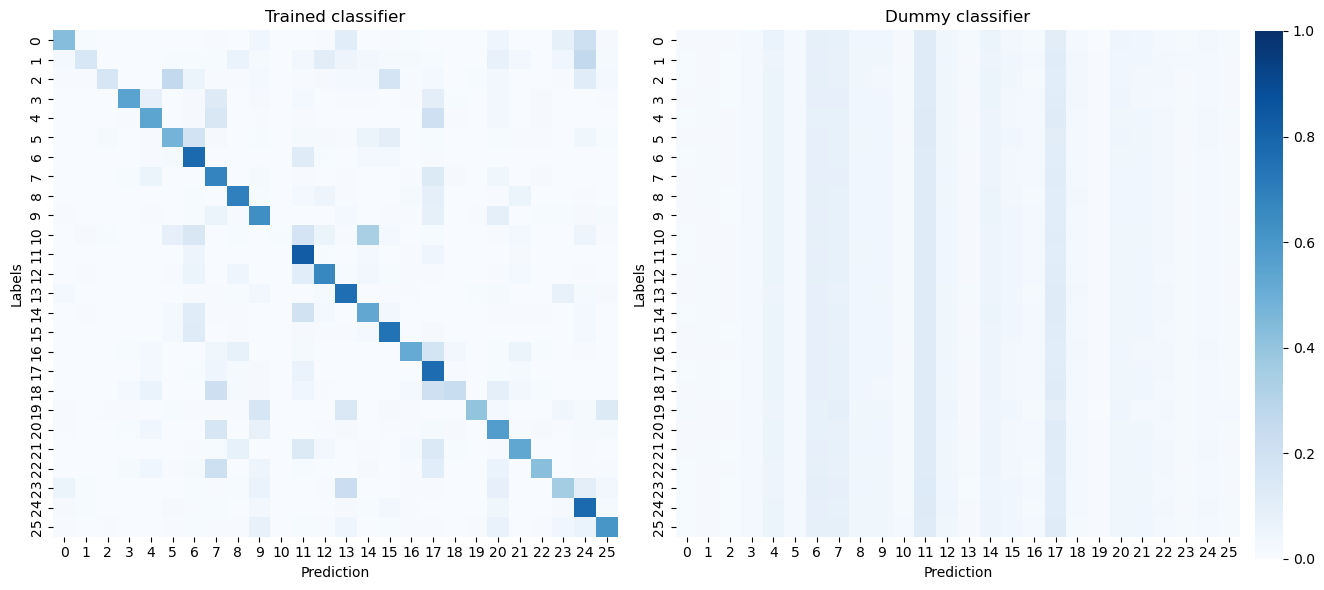

In [ ]:
classifier.evaluate_model('kmeans_label')

In [ ]:
model = classifier.train_model('n2v_kmeans_label')

Using the existing vectorized train set
Training model...
Model trained


Using existing vectorized test set

Evaluating actual model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.3987    0.0173    0.0332      3521
           1     0.4479    0.6304    0.5237     14930
           2     0.5583    0.7024    0.6221     15373
           3     0.4458    0.0895    0.1491     20266
           4     0.5403    0.8859    0.6712     40085
           5     0.6800    0.0310    0.0593      1097
           6     0.4510    0.2301    0.3047      3760
           7     0.7641    0.0653    0.1203     17168
           8     0.5145    0.4654    0.4888      3689
           9     0.5691    0.5508    0.5598     11190
          10     0.5000    0.0401    0.0742     10984
          11     0.6596    0.0683    0.1238      1815
          12     0.5736    0.6655    0.6162     19384
          13     0.4035    0.0900    0.1471      5858
          14     0.6291    0.0337    0.0640     12586
          15     0.3535    0.

/tmp/ipykernel_2869472/815905649.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


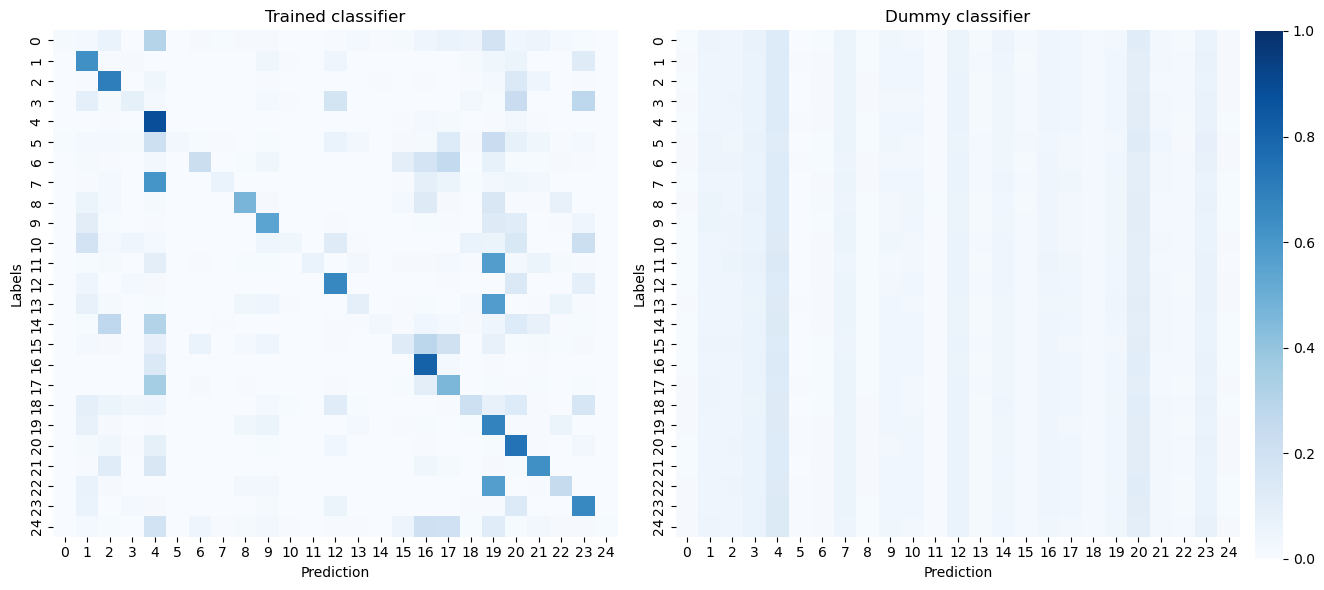

In [ ]:
classifier.evaluate_model('n2v_kmeans_label')

In [ ]:
model = classifier.train_model('cm_kmeans_label')

Using the existing vectorized train set
Training model...
Model trained


Using existing vectorized test set

Evaluating actual model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.6031    0.2445    0.3480      6281
           1     0.5763    0.6556    0.6134     79207
           2     0.8750    0.0114    0.0224       616
           3     0.5973    0.4718    0.5272      9324
           4     0.6271    0.6822    0.6535     26176
           5     0.6090    0.2064    0.3083      2355
           6     0.6108    0.3862    0.4732     18100
           7     0.6142    0.3616    0.4552      4513
           8     0.6910    0.6324    0.6604      8696
           9     0.7889    0.1033    0.1828       687
          10     0.6313    0.5032    0.5600      3893
          11     0.5833    0.0394    0.0738      2667
          12     0.0000    0.0000    0.0000       228
          13     0.5872    0.6054    0.5961      6181
          14     0.6667    0.6211    0.6431     18623
          15     0.7726    0.

/tmp/ipykernel_2869472/815905649.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


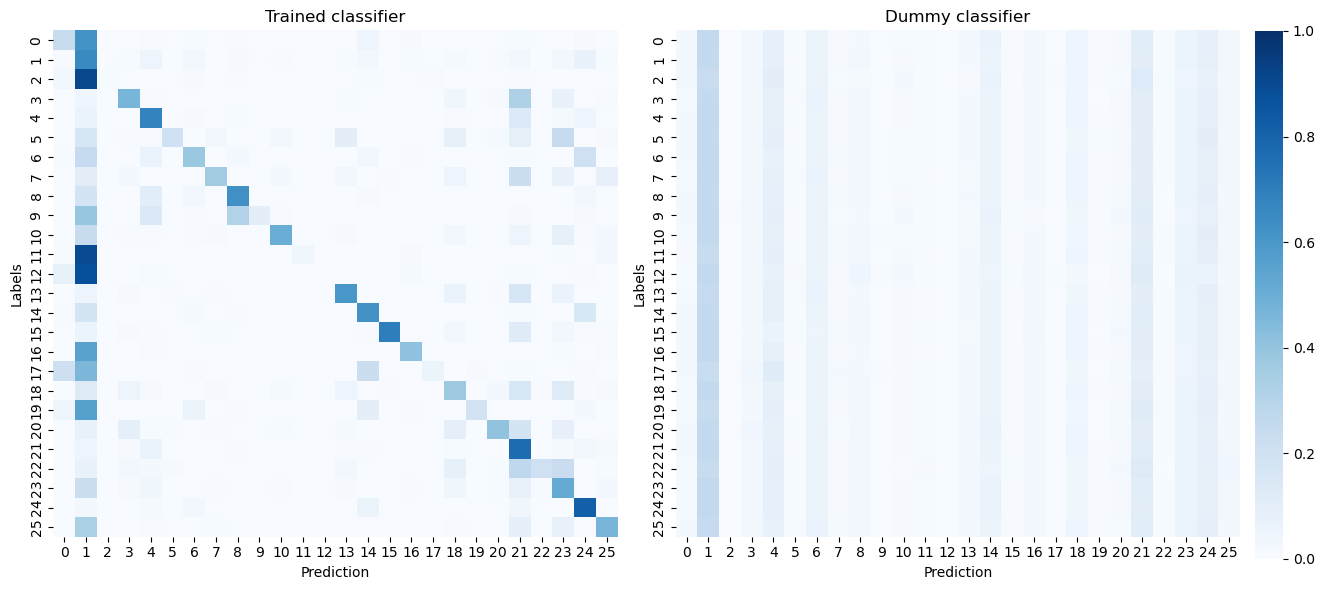

In [ ]:
classifier.evaluate_model('cm_kmeans_label')

In [ ]:
model = classifier.train_model('scopus_label')

Using the existing vectorized train set
Training model...
Model trained


Using existing vectorized test set

Evaluating actual model performance:
--------------------------------
                                              precision    recall  f1-score   support

        Agricultural and Biological Sciences     0.6450    0.8069    0.7169     20509
                         Arts and Humanities     0.7082    0.4205    0.5277      6124
Biochemistry, Genetics and Molecular Biology     0.5526    0.4733    0.5099     18280
         Business, Management and Accounting     0.6410    0.2973    0.4062      3915
                        Chemical Engineering     0.6598    0.0445    0.0834      3615
                                   Chemistry     0.6209    0.7425    0.6763     20611
                            Computer Science     0.5891    0.2256    0.3263      6094
                           Decision Sciences     0.3750    0.0081    0.0159       740
                                   Dentistry     0.7859    0.2756    0.4081      1865
                Earth and Planeta

/tmp/ipykernel_2869472/815905649.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


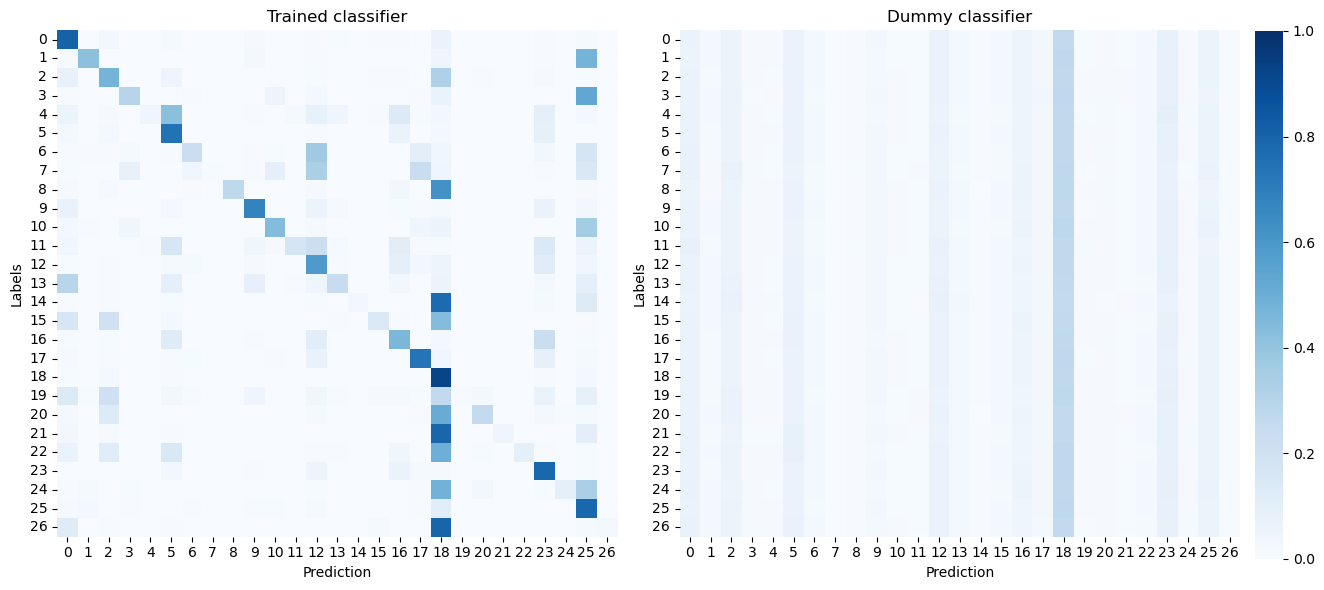

In [ ]:
classifier.evaluate_model('scopus_label')

# One-vs-rest clasiification

In [ ]:
label_to_method = {'kmeans_label': 'Periodical2Vec+$k$-means',
                   'skm_label': 'Periodical2Vec+Sperical $k$-means',
                   'movmf_label': 'Periodical2Vec+movMF',
                   
                   'bert_kmeans_label': 'BERT+$k$-means',
                   'n2v_kmeans_label': 'Node2Vec+$k$-means',
                   'cm_kmeans_label': 'Citation Matrix+$k$-means',
                   'gnn_kmeans_label': 'GNN+$k$-means',
                   'scopus_label': 'Scopus'
                   }

In [ ]:
classifier.one_vs_rest(model, label_to_method)

Dataset not found, preparing dataset...
Preparing dataset...
label types:  dict_keys(['cm_kmeans_label', 'scopus_label', 'movmf_label', 'bert_kmeans_label', 'skm_label', 'kmeans_label', 'gnn_kmeans_label', 'n2v_kmeans_label'])
Prepared dataset with 1527417 samples
Processing Fold 1/10
Fitting and applying TF-IDF on the train set...
Fitting TF-IDF finished
Applying TF-IDF on the test set...
Applying TF-IDF finished
Processing Periodical2Vec+$k$-means
Processing Periodical2Vec+Sperical $k$-means
Processing Periodical2Vec+movMF
Processing BERT+$k$-means
Processing Node2Vec+$k$-means
Processing Citation Matrix+$k$-means
Processing GNN+$k$-means
Processing Scopus
Processing Fold 2/10
Fitting and applying TF-IDF on the train set...
Fitting TF-IDF finished
Applying TF-IDF on the test set...
Applying TF-IDF finished
Processing Periodical2Vec+$k$-means
Processing Periodical2Vec+Sperical $k$-means
Processing Periodical2Vec+movMF
Processing BERT+$k$-means
Processing Node2Vec+$k$-means
Processing 

In [ ]:
import pickle

with open('/home/lyuzhuoqi/projects/clustering/tasks/roc_results.pkl', 'wb') as f:
    pickle.dump(classifier.roc_results, f)

In [ ]:
label_to_method = {'kmeans_label': 'Periodical2Vec+$k$-means',
                   'n2v_kmeans_label': 'Node2Vec+$k$-means',
                   'cm_kmeans_label': 'Citation Matrix+$k$-means',
                   'scopus_label': 'Scopus'}

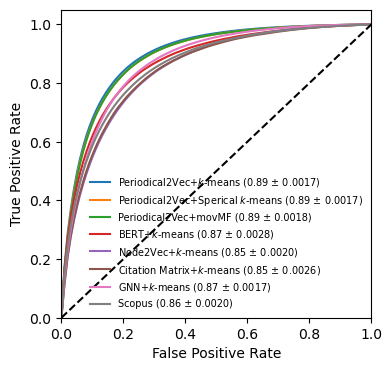

In [ ]:
import pickle
from scipy.stats import sem, t
# Plot ROC curves and save to file
fig =plt.figure(figsize=(4, 4))

with open('/home/lyuzhuoqi/projects/clustering/tasks/roc_results.pkl', 'rb') as f:
    roc_results = pickle.load(f)

for label_column, method_name in label_to_method.items():
    fpr_list = [result[0] for result in roc_results[label_column]]
    tpr_list = [result[1] for result in roc_results[label_column]]
    auc_list = [result[2] for result in roc_results[label_column]]
    
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    
    confidence = 0.95
    t_value = t.ppf((1 + confidence) / 2, df=classifier.n_splits - 1)
    std_error = sem([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    ci = t_value * std_error
    
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)
    
    plt.plot(
        mean_fpr, mean_tpr,
        label=f'{method_name} ({mean_auc:.2f} ± {std_auc:.4f})'
    )
    plt.fill_between(mean_fpr,
                     mean_tpr - ci,
                     mean_tpr + ci,
                     alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", fontsize=7, frameon=False)

# Display the plot
plt.show()

# Save the plot
fig.savefig('/home/lyuzhuoqi/projects/clustering/tasks/roc_curves.pdf', bbox_inches='tight', dpi=300)